### 100,000 UK Used Car Data set
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


1. Выбрать набор данных для своей группы: <br>
    3530203_70301: Mercedes<br>
    3530203_70302: Ford <br>
    <h3>3530903_70101: BMW</h3> <br>
    3530903_70102: Audi <br>
    
2. Разбить данные на тренировочные и тестовые (70% на 30%, random_state=10).
3. Применить доступные способы предобработки данных.
4. Попытаться обучить регрессию для предсказания цены автомобиля c наилучшим качеством. Качество оценивать по метрике RMSE на тестовой подвыборке. Попробовать различные модели регуляризации (и не только).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)
pd.set_option('precision', 3)
sns.set()

import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler

In [2]:
auto_df = pd.read_csv("bmw.csv")
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


model           - BMW model
year            - registration year
price           - price in £
transmission    - type of gearbox
mileage         - miles travelled
fuelType        - engine fuel (Diesel, Petrol, Other, Hybrid, Electric)
tax             - road tax (£)
mpg             - miles per gallon
engineSize      - in (L)

## 1. Data Preprocessing

In [3]:
auto_df.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [4]:
auto_df['model'].unique() # С моделями вроде как все нормально по данным

array([' 5 Series', ' 6 Series', ' 1 Series', ' 7 Series', ' 2 Series',
       ' 4 Series', ' X3', ' 3 Series', ' X5', ' X4', ' i3', ' X1', ' M4',
       ' X2', ' X6', ' 8 Series', ' Z4', ' X7', ' M5', ' i8', ' M2',
       ' M3', ' M6', ' Z3'], dtype=object)

Oldest car: 1996
Newest car: 2020


<AxesSubplot:>

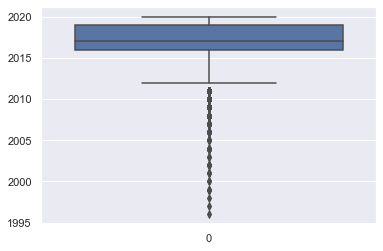

In [5]:
print('Oldest car:', auto_df['year'].min())
print('Newest car:', auto_df['year'].max())
sns.boxplot(data=auto_df['year']) #Данные от 1996 до 2020 - адекватные

Cheapest car: 1200
Most expensive car: 123456


<AxesSubplot:>

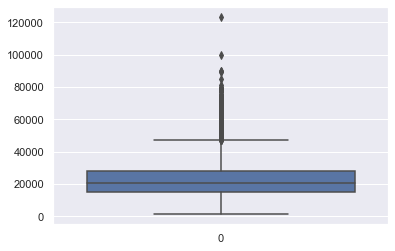

In [6]:
print('Cheapest car:', auto_df['price'].min())
print('Most expensive car:', auto_df['price'].max())
sns.boxplot(data=auto_df['price']) #Максимальное значение 123456 выглядит подозрительным. По auto.ru автомобиль Series 2 значительно дешевле - ошибка в данных.

In [7]:
drop_index = auto_df[auto_df['price'] == 123456].index
auto_df = auto_df.drop(drop_index)
auto_df[auto_df['price'] == auto_df['price'].max()] #вроде бы адекватная стоимость

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
5362,M4,2016,99950,Automatic,771,Petrol,300,33.2,3.0


In [8]:
auto_df['transmission'].unique() # Все нормально

array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object)

Min mileage: 1
Max mileage: 214000


<AxesSubplot:>

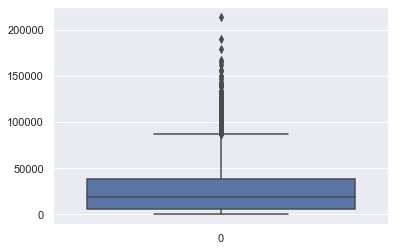

In [9]:
print('Min mileage:', auto_df['mileage'].min())
print('Max mileage:', auto_df['mileage'].max())
sns.boxplot(data=auto_df['mileage']) #Подозрительно, но вроде бы возможно

<AxesSubplot:>

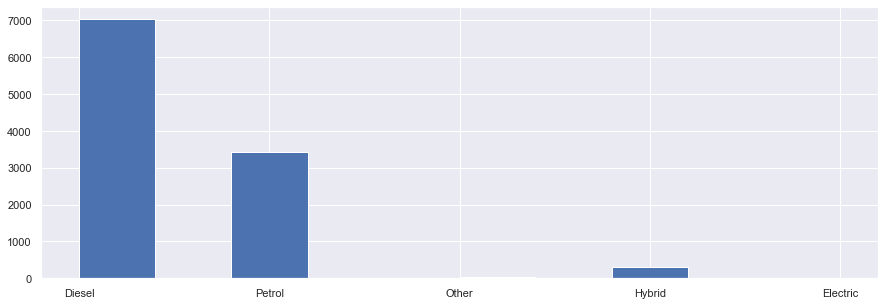

In [10]:
pd.Series(auto_df['fuelType']).hist(figsize=(15, 5))

In [11]:
print('Other:', (auto_df['fuelType'] == 'Other').sum())
print('Hybrid:', (auto_df['fuelType'] == 'Hybrid').sum())
print('Electric:', (auto_df['fuelType'] == 'Electric').sum()) #Всего 36 "Other" и 3 "Electric". Наверное - можно убрать их из рассмотрения

Other: 36
Hybrid: 298
Electric: 3


In [12]:
#drop_indexes = auto_df[auto_df.fuelType.isin(['Other', 'Electric'])].index
#auto_df = auto_df.drop(drop_indexes)

Lowest tax: 0
Highest tax: 580


<AxesSubplot:>

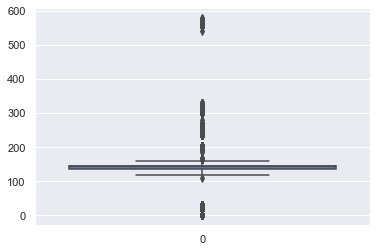

In [13]:
print('Lowest tax:', auto_df['tax'].min())
print('Highest tax:', auto_df['tax'].max())
sns.boxplot(data=auto_df['tax']) #Очень странно выглядит свеча. Плюс есть большой пробел между 400 и 500

In [14]:
auto_df['tax'].value_counts()
# Есть несколько налоговых ставок, которые встречаются только 1 раз. Удалять не буду, но обратить внимание стоит

145    5372
150    1241
30      989
125     844
20      484
160     432
0       340
200     337
165     118
135     117
205      98
300      84
235      71
260      60
140      36
325      26
305      25
555      17
265      14
240      13
330      12
570      12
565       9
270       5
120       4
195       3
315       3
190       2
245       2
580       2
110       1
185       1
540       1
155       1
250       1
255       1
130       1
280       1
Name: tax, dtype: int64

In [15]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10780 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10780 non-null  object 
 1   year          10780 non-null  int64  
 2   price         10780 non-null  int64  
 3   transmission  10780 non-null  object 
 4   mileage       10780 non-null  int64  
 5   fuelType      10780 non-null  object 
 6   tax           10780 non-null  int64  
 7   mpg           10780 non-null  float64
 8   engineSize    10780 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.1+ MB


Lowest mpg: 5.5
Highest mpg: 470.8


<AxesSubplot:>

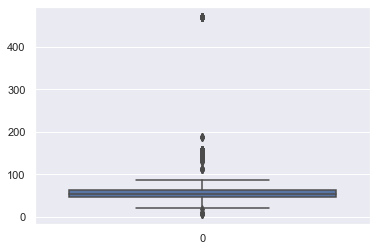

In [16]:
print('Lowest mpg:', auto_df['mpg'].min())
print('Highest mpg:', auto_df['mpg'].max())
sns.boxplot(data=auto_df['mpg']) #Очень странно выглядит свеча. Но точно видно выпадающее значение

In [17]:
auto_df[auto_df['mpg'] > 200]
#Что интересно - у них у всех размер двигателя в литрах - 0. Либо это какое-то особо значение, либо это ошибка в данных. Погуглил - автомобиль электрический, с газовым двигателем "на подстраховке". Здесь убирать смысла не вижу. Надо решать по engineSize = 0.

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
32,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6
621,i3,2017,19998,Automatic,41949,Hybrid,140,470.8,0.0
778,i3,2017,19998,Automatic,41146,Hybrid,0,470.8,0.0
780,i3,2017,21898,Automatic,10839,Hybrid,0,470.8,0.0
1866,i3,2017,19980,Automatic,26965,Hybrid,140,470.8,0.0
2352,i3,2016,19490,Automatic,8421,Hybrid,0,470.8,0.0
3277,i3,2016,16482,Automatic,43695,Hybrid,0,470.8,0.0
3628,i3,2015,14285,Automatic,65800,Hybrid,0,470.8,0.0
3913,i3,2017,18500,Automatic,36429,Hybrid,0,470.8,0.0
4100,i3,2017,19495,Automatic,17338,Hybrid,135,470.8,0.0


Lowest engine size: 0.0
Highest engine size: 6.6


<AxesSubplot:>

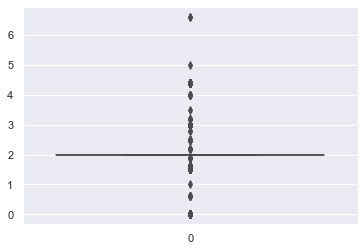

In [18]:
print('Lowest engine size:', auto_df['engineSize'].min())
print('Highest engine size:', auto_df['engineSize'].max())
sns.boxplot(data=auto_df['engineSize']) #Двигатели объема ноль выглядят странно

In [19]:
auto_df[auto_df['engineSize'] == 0]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
621,i3,2017,19998,Automatic,41949,Hybrid,140,470.8,0.0
778,i3,2017,19998,Automatic,41146,Hybrid,0,470.8,0.0
780,i3,2017,21898,Automatic,10839,Hybrid,0,470.8,0.0
1866,i3,2017,19980,Automatic,26965,Hybrid,140,470.8,0.0
2352,i3,2016,19490,Automatic,8421,Hybrid,0,470.8,0.0
3277,i3,2016,16482,Automatic,43695,Hybrid,0,470.8,0.0
3628,i3,2015,14285,Automatic,65800,Hybrid,0,470.8,0.0
3913,i3,2017,18500,Automatic,36429,Hybrid,0,470.8,0.0
4100,i3,2017,19495,Automatic,17338,Hybrid,135,470.8,0.0
4109,i3,2015,17481,Automatic,9886,Hybrid,0,470.8,0.0


In [20]:
auto_df[auto_df['engineSize'] > 3].sort_values(by='engineSize')

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
10724,M3,2005,10999,Manual,115000,Petrol,315,20.8,3.2
9233,M3,2004,16950,Manual,80000,Petrol,330,23.7,3.2
9836,M3,2004,17850,Manual,60000,Petrol,325,23.3,3.2
9837,M3,2004,19500,Manual,46000,Petrol,325,23.3,3.2
7562,M3,2004,14950,Automatic,55000,Petrol,315,23.3,3.2
...,...,...,...,...,...,...,...,...,...
5598,M5,2018,61792,Automatic,5856,Petrol,145,26.9,4.4
6838,M5,2016,36494,Semi-Auto,25780,Petrol,565,28.5,4.4
9229,M6,2006,12495,Semi-Auto,89000,Petrol,570,19.1,5.0
9799,7 Series,2017,57000,Automatic,11297,Petrol,145,22.1,6.6


In [21]:
#drop_indexes = auto_df[auto_df['engineSize'] == 0].index
#auto_df = auto_df.drop(drop_indexes)
#auto_df[auto_df['engineSize'] == 0]

#### Price 123456 - явно ошибка в данных
#### Тип топлива 'Electric' и 'Other' суммарно меньше 50 вхождений - возможно их следует удалить
#### mpg = 470.8 встречается только у модели i3 - странное выпадающее значение - возможно следует удалить
#### engineSize = 0 - пустое значение
#### engineSize = 5 и 6.6 - стоит проверить, может быть ошибкой

## 2. Basic Data Analysis

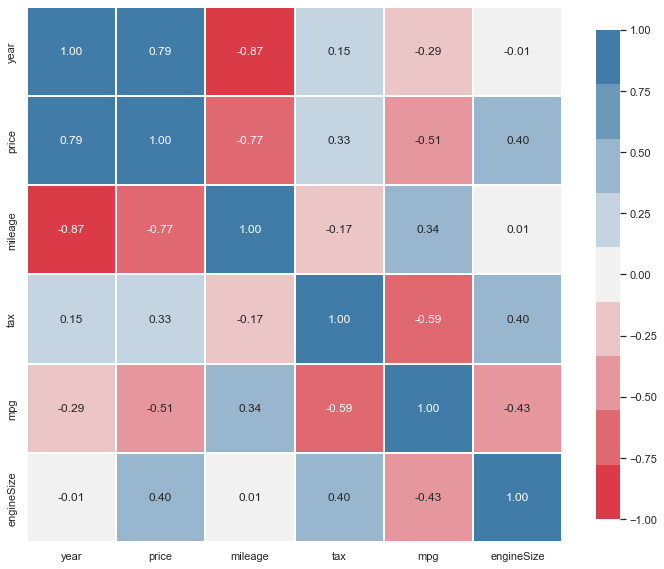

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(10, 240, n=9)

# Plot heat map
data_corr = auto_df.corr(method='spearman')
sns.heatmap(data_corr, annot=True, fmt=".2f",
            linewidths=2, cmap=cmap, vmin=-1, vmax=1,
            cbar_kws={"shrink": .9}, square=True);

#### Чем выше цена, тем моложе автомобиль и больше размер двигателя
#### Чем больше пробег, тем больше возраст и меньше цена
#### Слабая взаимосвязь "чем больше цена, тем больше налоги"

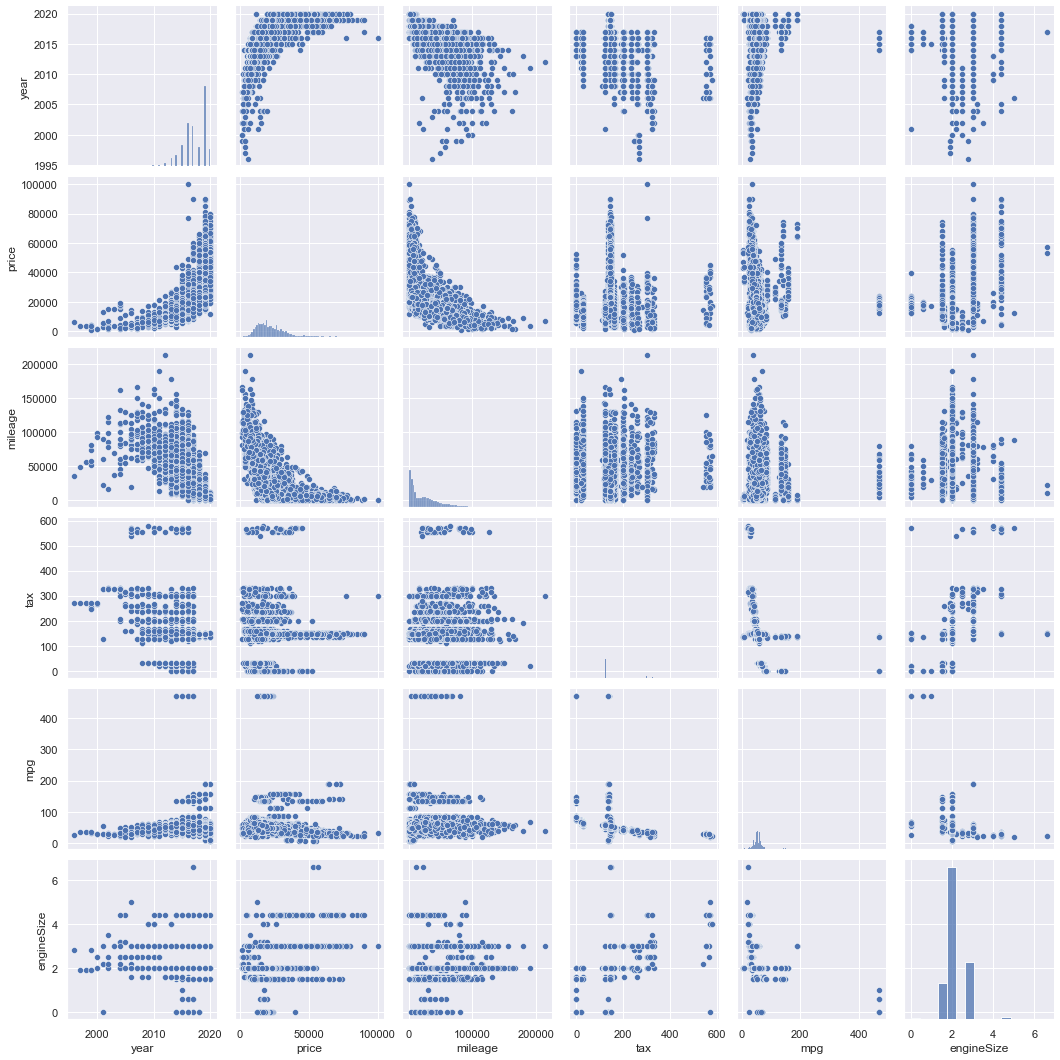

In [23]:
sns.pairplot(auto_df)

#### Зависимость стоимости от года регистрации машины и от пробега выглядит, как ветвь параболы

## 3. Train / Test Splitting

In [24]:
auto_df = pd.get_dummies(auto_df)
auto_df

,year,price,mileage,tax,mpg,engineSize,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,...,model_ i3,model_ i8,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2014,11200,67068,125,57.6,2.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2018,27000,14827,145,42.8,2.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,2016,16000,62794,160,51.4,3.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,2017,12750,26676,145,72.4,1.5,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,2014,14500,39554,160,50.4,3.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776,2016,19000,40818,150,54.3,2.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
10777,2016,14600,42947,125,60.1,2.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
10778,2017,13100,25468,200,42.8,2.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
10779,2014,9930,45000,30,64.2,2.0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [25]:
X, Y = auto_df.drop(['price'], axis=1), auto_df['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [26]:
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

X_train_scaled

array([[-0.032,  0.436,  0.215, ..., -0.167, -0.056, -0.684],
       [-0.883,  1.203, -1.622, ..., -0.167, -0.056, -0.684],
       [ 0.393, -0.558,  0.295, ..., -0.167, -0.056, -0.684],
       ...,
       [ 0.818, -1.006,  0.215, ..., -0.167, -0.056, -0.684],
       [-0.032, -0.303,  0.215, ..., -0.167, -0.056,  1.461],
       [-0.032, -0.387,  0.215, ..., -0.167, -0.056, -0.684]])

## 4. Baseline Model

In [27]:
Y_mean = Y_train.mean()
dummy_LR_predictions = np.full(len(Y_test), Y_mean)
dummy_LR_RMSE = metrics.mean_squared_error(Y_test, dummy_LR_predictions, squared=False)

In [28]:
print('Test std =', Y_test.std())
print('Dummy RMSE =', dummy_LR_RMSE)

Test std = 11302.080413609587
Dummy RMSE = 11300.339130073908


## 5. Simple Linear Model

In [29]:
simple_LR = LinearRegression()
simple_LR.fit(X_train_scaled, Y_train)
simple_LR_predictions = simple_LR.predict(X_test_scaled)
simple_LR_RMSE = metrics.mean_squared_error(Y_test, simple_LR_predictions, squared=False)
print('Test std =', Y_test.std())
print('Linear Regression RMSE =', simple_LR_RMSE)

Test std = 11302.080413609587
Linear Regression RMSE = 3973.3932294335855


Text(0, 0.5, 'Target')

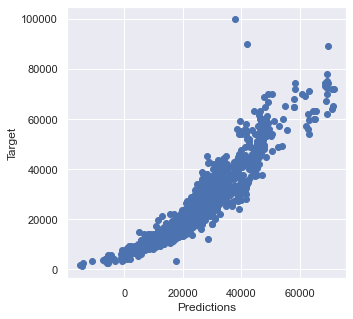

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(simple_LR_predictions, Y_test)
plt.xlabel('Predictions')
plt.ylabel('Target')

In [31]:
pd.DataFrame(simple_LR.coef_, auto_df.columns[1:], columns=['Coefficients'])

,Coefficients
price,4.239e+03
mileage,-2.885e+03
tax,-6.371e+02
mpg,-3.756e+03
engineSize,2.067e+03
model_ 1 Series,1.279e+14
model_ 2 Series,1.060e+14
model_ 3 Series,1.388e+14
model_ 4 Series,9.718e+13
model_ 5 Series,9.856e+13


## 6. Regularization

In [32]:
model = Lasso()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print(f'Lasso RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.coef_, auto_df.columns[1:], columns=['Coefficients'])

Lasso RMSE = 3973.803


,Coefficients
price,4241.672
mileage,-2883.814
tax,-631.953
mpg,-3727.547
engineSize,2068.951
model_ 1 Series,-1942.835
model_ 2 Series,-1653.961
model_ 3 Series,-946.309
model_ 4 Series,-709.891
model_ 5 Series,-93.603


In [33]:
model = LassoCV(random_state=10)

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'Lasso CV RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.coef_, auto_df.columns[1:], columns=['Coefficients'])

Lasso CV RMSE = 3977.564


,Coefficients
price,4240.585
mileage,-2880.796
tax,-601.008
mpg,-3546.751
engineSize,2093.509
model_ 1 Series,-1542.902
model_ 2 Series,-1319.522
model_ 3 Series,-508.823
model_ 4 Series,-406.100
model_ 5 Series,203.346


In [34]:
model = Ridge()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'Ridge RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.coef_, auto_df.columns[1:], columns=['Coefficients'])

Ridge RMSE = 3973.373


,Coefficients
price,4241.161
mileage,-2884.332
tax,-635.527
mpg,-3746.241
engineSize,2066.604
model_ 1 Series,-1737.461
model_ 2 Series,-1484.235
model_ 3 Series,-724.746
model_ 4 Series,-554.635
model_ 5 Series,63.298


In [35]:
model = RidgeCV()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'Ridge CV RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.coef_, auto_df.columns[1:], columns=['Coefficients'])

Ridge CV RMSE = 3974.354


,Coefficients
price,4234.956
mileage,-2886.833
tax,-624.551
mpg,-3652.544
engineSize,2074.013
model_ 1 Series,-1737.105
model_ 2 Series,-1482.663
model_ 3 Series,-722.814
model_ 4 Series,-555.177
model_ 5 Series,62.474


In [36]:
alphas = np.linspace(1, 10, 20)
alphas

array([ 1.   ,  1.474,  1.947,  2.421,  2.895,  3.368,  3.842,  4.316,
        4.789,  5.263,  5.737,  6.211,  6.684,  7.158,  7.632,  8.105,
        8.579,  9.053,  9.526, 10.   ])

In [37]:
model = LassoCV(random_state = 10, alphas=alphas)

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'Lasso CV RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.coef_, auto_df.columns[1:], columns=['Coefficients'])

Lasso CV RMSE = 3973.803


,Coefficients
price,4241.672
mileage,-2883.814
tax,-631.953
mpg,-3727.547
engineSize,2068.951
model_ 1 Series,-1942.835
model_ 2 Series,-1653.961
model_ 3 Series,-946.309
model_ 4 Series,-709.891
model_ 5 Series,-93.603


## 7. Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 10, n_estimators = 100)

model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.feature_importances_, auto_df.columns[1:],
             columns=['Importance']).sort_values('Importance')

RMSE = 2539.41


,Importance
model_ Z3,1.314e-06
fuelType_Electric,2.029e-06
model_ i3,1.521e-05
model_ M6,1.984e-05
fuelType_Other,2.215e-05
model_ M2,4.709e-05
model_ M3,1.787e-04
model_ Z4,1.870e-04
model_ X2,6.261e-04
model_ M5,7.072e-04


In [39]:
model.score(X_test, Y_test)

0.9495009436348921

Text(0, 0.5, 'Target')

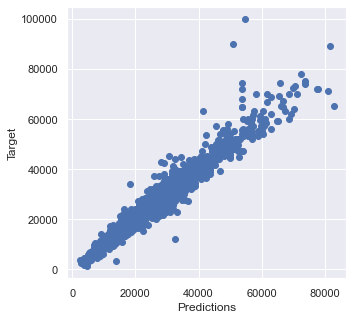

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(predictions, Y_test)
plt.xlabel('Predictions')
plt.ylabel('Target')